# INFO 5613 – Class 13: Community structure

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Import libraries

In [1]:
# Load networkx for working with network data
import networkx as nx

# Load numpy for working with numerical data
import numpy as np

# Load pandas for working with tabular data
import pandas as pd

# Load visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb

# Load libraries
import os
import random
import json, requests
from itertools import combinations


# Define a formatting string we can use to print the number of nodes and edges
node_edge_s = "There are {0:,} nodes and {1:,} edges in the network"

### Helper functions

In [2]:
def visualize_network(g,k=1,weight='weight',labels=True,node_scale=300,font_size=8):
    # Create an empty canvas
    f,ax = plt.subplots(figsize=(10,10))

    # Compute node positions
    pos = nx.drawing.spring_layout(g,k=k,seed=42,iterations=100)

    # Calculate centralities
    centrality = nx.degree_centrality(g)

    # Draw the nodes, sized by centrality
    nx.draw_networkx_nodes(g,
                           pos=pos,
                           node_size=[v*node_scale for n,v in centrality.items()],
                           ax=ax
                          )

    # Draw the edges, sized by weight (number of scenes together)
    if weight is not None:
        nx.draw_networkx_edges(g,
                           pos=pos,
                           alpha=.5,
                           width=[d[weight] for i,j,d in g.edges(data=True)],
                           ax=ax
                          )
    else:
        nx.draw_networkx_edges(g,
                           pos=pos,
                           alpha=.5,
                           ax=ax
                          )

    if labels:
    # Draw the node labels
        nx.draw_networkx_labels(g,
                                pos=pos,
                                font_size=font_size,
                                verticalalignment='bottom',
                                ax=ax
                               );
    
    return f,ax

In [3]:
def largest_component(g):
    _nodes = sorted(nx.components.connected_components(g),key=len,reverse=True)[0]
    return nx.subgraph(g,_nodes)

## Load data

### *Game of Thrones* character co-occurrences

In [ ]:
# Get the data
got_episodes_json = requests.get('https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/episodes.json').json()

episodes_by_season = {}

for e in got_episodes_json['episodes']:
    if e['seasonNum'] in episodes_by_season.keys():
        episodes_by_season[e['seasonNum']].append(e)
    else:
        episodes_by_season[e['seasonNum']] = [e]

In [ ]:
season_got_d = {}

# For each set of seasons of episodes
for season_num, episode_list in episodes_by_season.items():
    
    # Create a season-level grpah
    _g = nx.Graph()
    
    # For each episode in the season
    for _e in episode_list:
        
        # Get the scenes
        _scenes = _e['scenes']

        # For each scene
        for _s in _scenes:

            # Make the character combinations
            _combos = list(combinations([c['name'] for c in _s['characters']],2))

            # For each character combination
            for (char1,char2) in _combos:

                # Check if the character combination is already in the network
                if _g.has_edge(char1,char2):

                    # If it is, increment the edge weight by 1
                    _g[char1][char2]['weight'] += 1

                else:
                    # If it is not, add the nodes and the edge with a weight of 1
                    _g.add_edge(char1,char2,weight=1)


    print("There are {0:,} nodes and {1:,} edges in season {2}.".format(_g.number_of_nodes(),_g.number_of_edges(),season_num))
    season_got_d[season_num] = _g

In [ ]:
visualize_network(season_got_d[4],k=.5,labels=False)

### Karate club

This is [one of the most famous datasets](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) in network science. Wayne Zachary collected network data on interactions among a 34-member karate club between 1970 and 1972. A conflict came up and the group split in two between a teacher "Mr. Hi" and an administrator. Each side tried to recruit other club memebers to their side. It has become a classic for evaluating community structure because of the clear outcome and there's a trophy that circulates among network scientists who use the datase at conferences: https://networkkarate.tumblr.com/

In [4]:
karate_g = nx.karate_club_graph()

karate_g.nodes(data=True)

NodeDataView({0: {'club': 'Mr. Hi'}, 1: {'club': 'Mr. Hi'}, 2: {'club': 'Mr. Hi'}, 3: {'club': 'Mr. Hi'}, 4: {'club': 'Mr. Hi'}, 5: {'club': 'Mr. Hi'}, 6: {'club': 'Mr. Hi'}, 7: {'club': 'Mr. Hi'}, 8: {'club': 'Mr. Hi'}, 9: {'club': 'Officer'}, 10: {'club': 'Mr. Hi'}, 11: {'club': 'Mr. Hi'}, 12: {'club': 'Mr. Hi'}, 13: {'club': 'Mr. Hi'}, 14: {'club': 'Officer'}, 15: {'club': 'Officer'}, 16: {'club': 'Mr. Hi'}, 17: {'club': 'Mr. Hi'}, 18: {'club': 'Officer'}, 19: {'club': 'Mr. Hi'}, 20: {'club': 'Officer'}, 21: {'club': 'Mr. Hi'}, 22: {'club': 'Officer'}, 23: {'club': 'Officer'}, 24: {'club': 'Officer'}, 25: {'club': 'Officer'}, 26: {'club': 'Officer'}, 27: {'club': 'Officer'}, 28: {'club': 'Officer'}, 29: {'club': 'Officer'}, 30: {'club': 'Officer'}, 31: {'club': 'Officer'}, 32: {'club': 'Officer'}, 33: {'club': 'Officer'}})

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

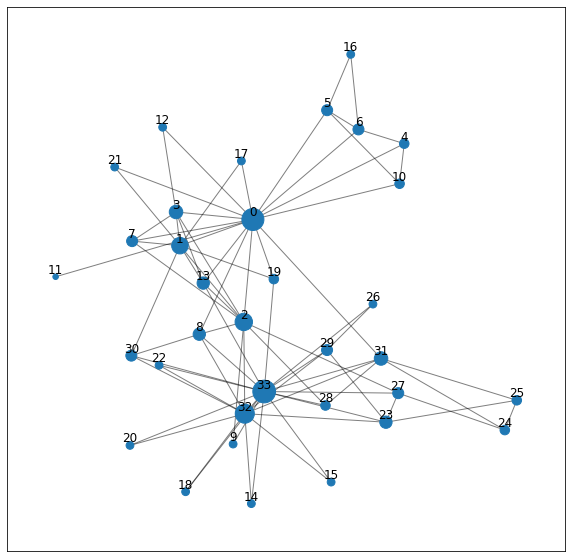

In [5]:
visualize_network(karate_g,weight=None,font_size=12,node_scale=1000)

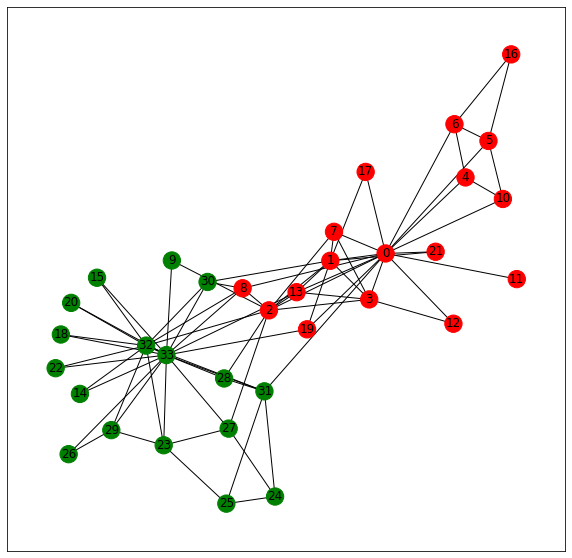

In [6]:
f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    karate_g,
    with_labels=True,
    ax=ax,
    node_color=pd.Categorical(nx.get_node_attributes(karate_g,'club').values()).codes,
    cmap=mcolors.ListedColormap(['red','green'])
)

## Clique

A "maximal clique" is a subset of nodes where every node is connected. This is the stricted definition of a subgroup. Some maximal cliques are "trivial" in the sense that it is a dyad of two nodes. A "non-trivial clique" would be a set of 3 or more nodes.

In [7]:
list(nx.find_cliques(karate_g))

[[0, 1, 17],
 [0, 1, 2, 3, 13],
 [0, 1, 2, 3, 7],
 [0, 1, 19],
 [0, 1, 21],
 [0, 4, 10],
 [0, 4, 6],
 [0, 5, 10],
 [0, 5, 6],
 [0, 8, 2],
 [0, 11],
 [0, 12, 3],
 [0, 31],
 [1, 30],
 [2, 32, 8],
 [2, 9],
 [2, 27],
 [2, 28],
 [5, 16, 6],
 [33, 32, 8, 30],
 [33, 32, 14],
 [33, 32, 15],
 [33, 32, 18],
 [33, 32, 20],
 [33, 32, 22],
 [33, 32, 23, 29],
 [33, 32, 31],
 [33, 9],
 [33, 13],
 [33, 19],
 [33, 26, 29],
 [33, 27, 23],
 [33, 28, 31],
 [24, 25, 31],
 [24, 27],
 [25, 23]]

In [9]:
# Focus on cliques that have at least three members
nontrivial_cliques_karate_g = [i for i in nx.find_cliques(karate_g) if len(i) > 3]
nontrivial_cliques_karate_g

[[0, 1, 2, 3, 13], [0, 1, 2, 3, 7], [33, 32, 8, 30], [33, 32, 23, 29]]

## Stochastic block models

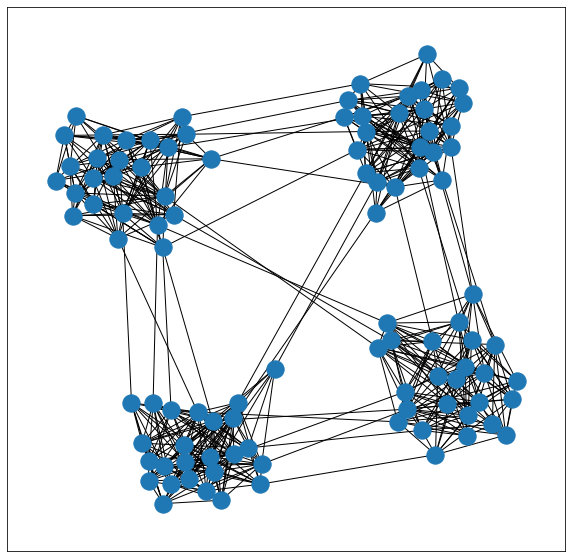

In [51]:
# Make a network with easily-distinguishable sub-communities
cluster_sizes = [25,25,25,25]
cluster_probabilities = [[.5,.01,.01,.01],[.01,.5,.01,.01],[.01,.01,.5,.01],[.01,.01,.01,.5]]

sbm_easy_g = nx.stochastic_block_model(cluster_sizes,cluster_probabilities)

f,ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(sbm_easy_g,with_labels=False,ax=ax)

In [11]:
# The generated graph includes meta-data about the "true" community assignments
sbm_easy_g.nodes(data=True)

NodeDataView({0: {'block': 0}, 1: {'block': 0}, 2: {'block': 0}, 3: {'block': 0}, 4: {'block': 0}, 5: {'block': 0}, 6: {'block': 0}, 7: {'block': 0}, 8: {'block': 0}, 9: {'block': 0}, 10: {'block': 0}, 11: {'block': 0}, 12: {'block': 0}, 13: {'block': 0}, 14: {'block': 0}, 15: {'block': 0}, 16: {'block': 0}, 17: {'block': 0}, 18: {'block': 0}, 19: {'block': 0}, 20: {'block': 0}, 21: {'block': 0}, 22: {'block': 0}, 23: {'block': 0}, 24: {'block': 0}, 25: {'block': 1}, 26: {'block': 1}, 27: {'block': 1}, 28: {'block': 1}, 29: {'block': 1}, 30: {'block': 1}, 31: {'block': 1}, 32: {'block': 1}, 33: {'block': 1}, 34: {'block': 1}, 35: {'block': 1}, 36: {'block': 1}, 37: {'block': 1}, 38: {'block': 1}, 39: {'block': 1}, 40: {'block': 1}, 41: {'block': 1}, 42: {'block': 1}, 43: {'block': 1}, 44: {'block': 1}, 45: {'block': 1}, 46: {'block': 1}, 47: {'block': 1}, 48: {'block': 1}, 49: {'block': 1}, 50: {'block': 2}, 51: {'block': 2}, 52: {'block': 2}, 53: {'block': 2}, 54: {'block': 2}, 55: {'

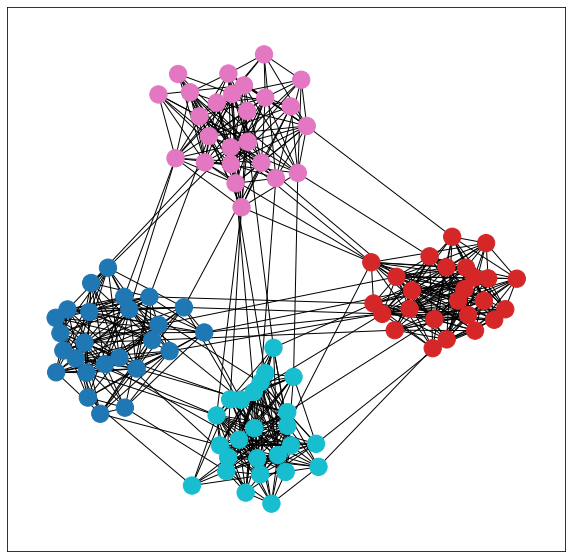

In [12]:
# Visualize with color
f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    sbm_easy_g,
    with_labels=False,
    ax=ax,
    node_color=list(nx.get_node_attributes(sbm_easy_g,'block').values()),
    cmap='tab10'
)

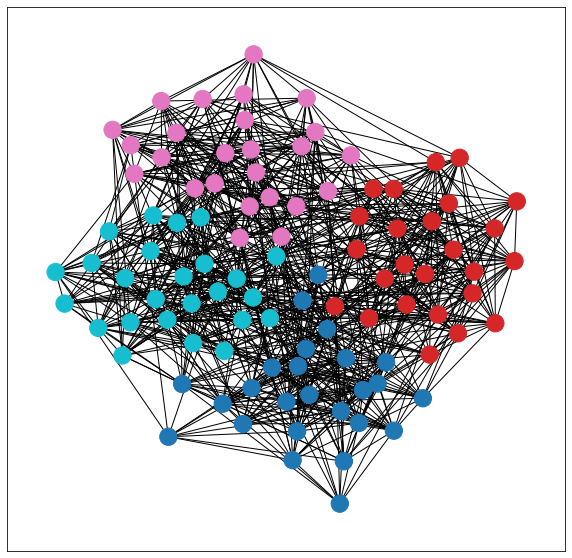

In [15]:
# Make another SBM with denser inter-group links
cluster_sizes = [25,25,25,25]
cluster_probabilities = [[.5,.1,.1,.1],[.1,.5,.1,.1],[.1,.1,.5,.1],[.1,.1,.1,.5]]

sbm_medium_g = nx.stochastic_block_model(cluster_sizes,cluster_probabilities)

f,ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(
    sbm_medium_g,
    with_labels=False,
    ax=ax,
    node_color=list(nx.get_node_attributes(sbm_medium_g,'block').values()),
    cmap='tab10'
)

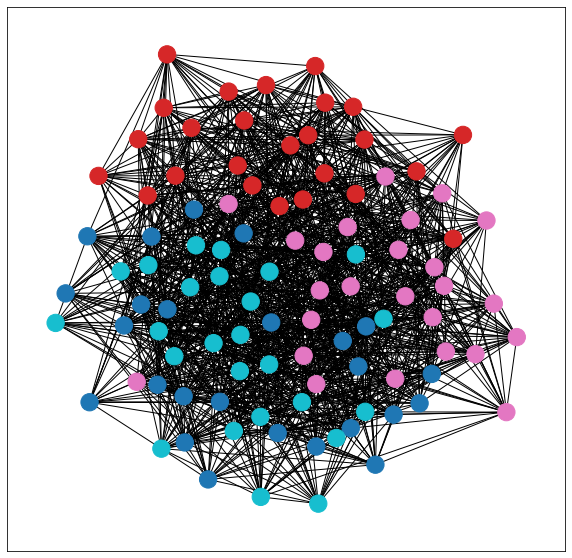

In [18]:
# Make another SBM with denser inter-group links
cluster_sizes = [25,25,25,25]
cluster_probabilities = [[.5,.2,.2,.2],[.2,.5,.2,.2],[.2,.2,.5,.2],[.2,.2,.2,.5]]

sbm_hard_g = nx.stochastic_block_model(cluster_sizes,cluster_probabilities)

f,ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(
    sbm_hard_g,
    with_labels=False,
    ax=ax,
    node_color=list(nx.get_node_attributes(sbm_hard_g,'block').values()),
    cmap='tab10'
)

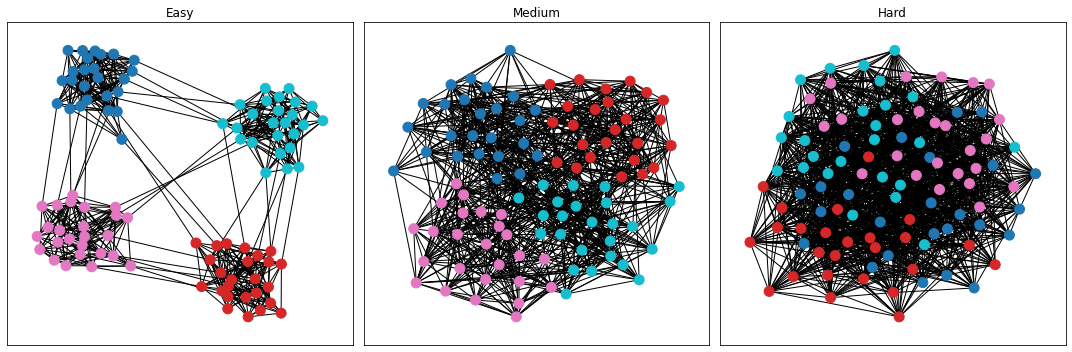

In [161]:
f,axs = plt.subplots(1,3,figsize=(15,5))

for i,g in enumerate([sbm_easy_g,sbm_medium_g,sbm_hard_g]):
    nx.draw_networkx(
        g,
        with_labels=False,
        ax=axs[i],
        node_size=100,
        node_color=list(nx.get_node_attributes(g,'block').values()),
        cmap='tab10'
    )

axs[0].set_title('Easy')
axs[1].set_title('Medium')
axs[2].set_title('Hard')

f.tight_layout()
f.set_facecolor('w')
f.savefig('sbm_easy_med_hard.png',dpi=300,bbox_inches='tight')

## Community detection

In [19]:
ground_truth = pd.Series(nx.get_node_attributes(sbm_hard_g,'block')).reset_index().groupby(0).agg(list).values
ground_truth = [i[0] for i in ground_truth.tolist()]

In [20]:
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.partition_quality.html
print(nx.community.partition_quality(sbm_easy_g,ground_truth))

(0.9311926605504587, 0.8715151515151515)


In [21]:
print(nx.community.modularity(sbm_easy_g,ground_truth))

0.6796437355628502


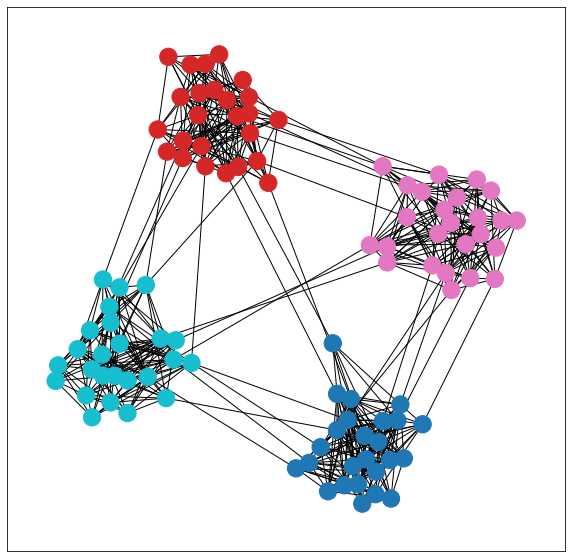

In [128]:
# Visualize with color
f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    sbm_easy_g,
    with_labels=False,
    ax=ax,
    node_color=list(nx.get_node_attributes(sbm_easy_g,'block').values()),
    cmap='tab10'
)

### k-cliques

In [147]:
kclique_nodesets = [list(i) for i in nx.community.k_clique_communities(sbm_easy_g,k=4)]
# print(nx.community.partition_quality(sbm_easy_g,kclique_nodesets))
kclique_assignments = {n:i for i,s in dict(enumerate(kclique_nodesets)).items() for n in s}

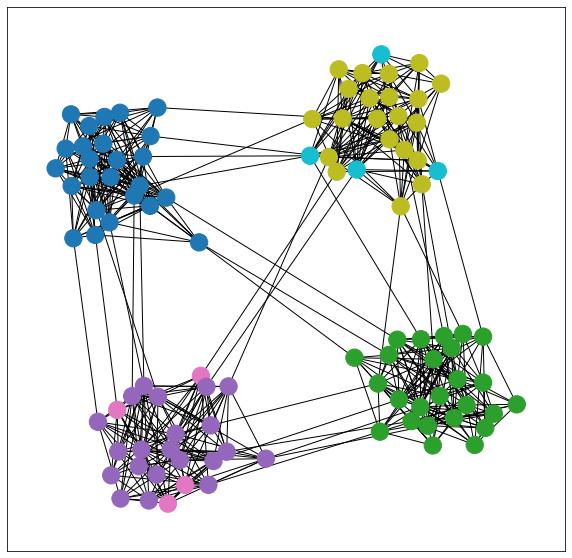

In [148]:
# Visualize with color
f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    sbm_easy_g,
    with_labels=False,
    ax=ax,
    node_color=list(kclique_assignments.values()),
    cmap='tab10'
)

### Modularity

In [142]:
modularity_nodesets = list(nx.community.greedy_modularity_communities(sbm_easy_g,resolution=.1))
print(nx.community.partition_quality(sbm_easy_g,modularity_nodesets))
modularity_assignments = {n:i for i,s in dict(enumerate(modularity_nodesets)).items() for n in s}

(0.9772727272727273, 0.49757575757575756)


In [143]:
print(nx.community.modularity(sbm_easy_g,modularity_nodesets))

0.37396694214876036


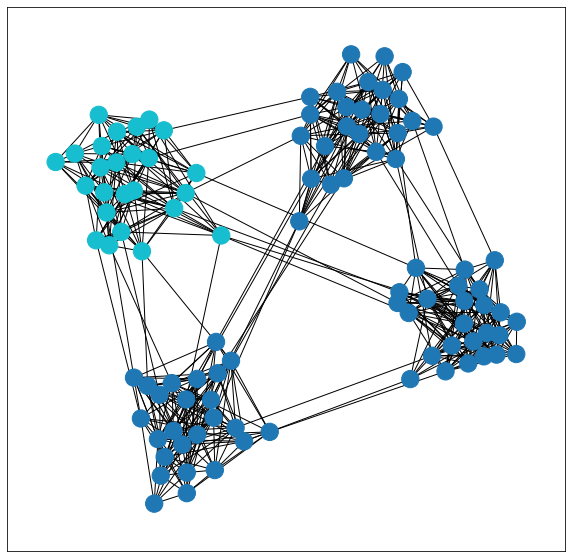

In [144]:
# Visualize with color
f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    sbm_easy_g,
    with_labels=False,
    ax=ax,
    node_color=list(modularity_assignments.values()),
    cmap='tab10'
)

### Label propagation

In [33]:
lp_nodesets = list(nx.community.label_propagation_communities(sbm_easy_g))
print(nx.community.partition_quality(sbm_easy_g,lp_nodesets))
lp_assignments = {n:i for i,s in dict(enumerate(lp_nodesets)).items() for n in s}

(0.9418960244648318, 0.7480808080808081)


In [34]:
print(nx.community.modularity(sbm_easy_g,lp_nodesets))

0.5738913204088695


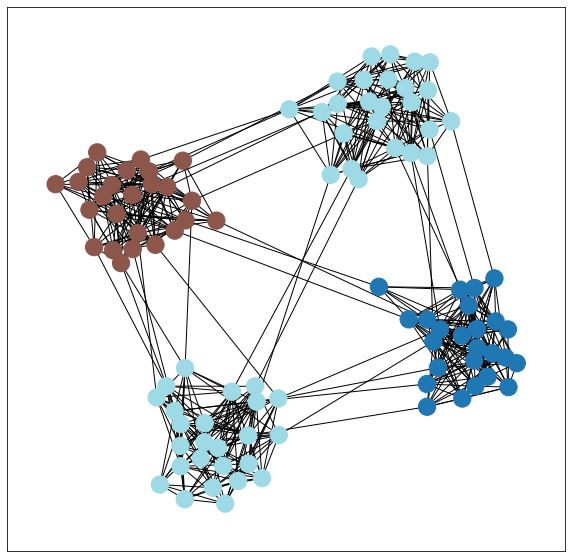

In [123]:
# Visualize with color
f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    sbm_easy_g,
    with_labels=False,
    ax=ax,
    node_color=list(lp_assignments.values()),
    cmap='tab20'
)

### Girvan-Newman

In [116]:
gn_nodesets = list(nx.community.girvan_newman(sbm_easy_g))

In [ ]:
# Identify a few different partitions
gn_partitions = {
    0:gn_nodesets[0],
    1:gn_nodesets[1],
    2:gn_nodesets[2],
    4:gn_nodesets[4],
    8:gn_nodesets[8],
    16:gn_nodesets[16],
    32:gn_nodesets[32],
    64:gn_nodesets[64],
    96:gn_nodesets[96],
}

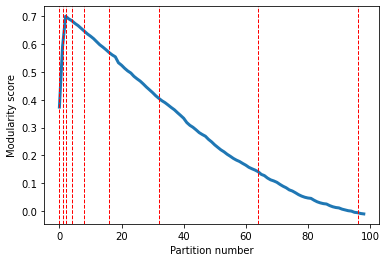

In [153]:
gn_modularity_d = {}

for i,ns in enumerate(gn_nodesets):
    gn_modularity_d[i] = nx.community.modularity(sbm_easy_g,ns)
    
ax = pd.Series(gn_modularity_d).plot(lw=3)
ax.set_xlabel('Partition number')
ax.set_ylabel('Modularity score')

# Annotate where we'll look at the network
for v in gn_partitions.keys():
    ax.axvline(v,c='r',lw=1,ls='--')

ax.set_facecolor('w')
plt.savefig('girvan_newman_modularity_scores.png')

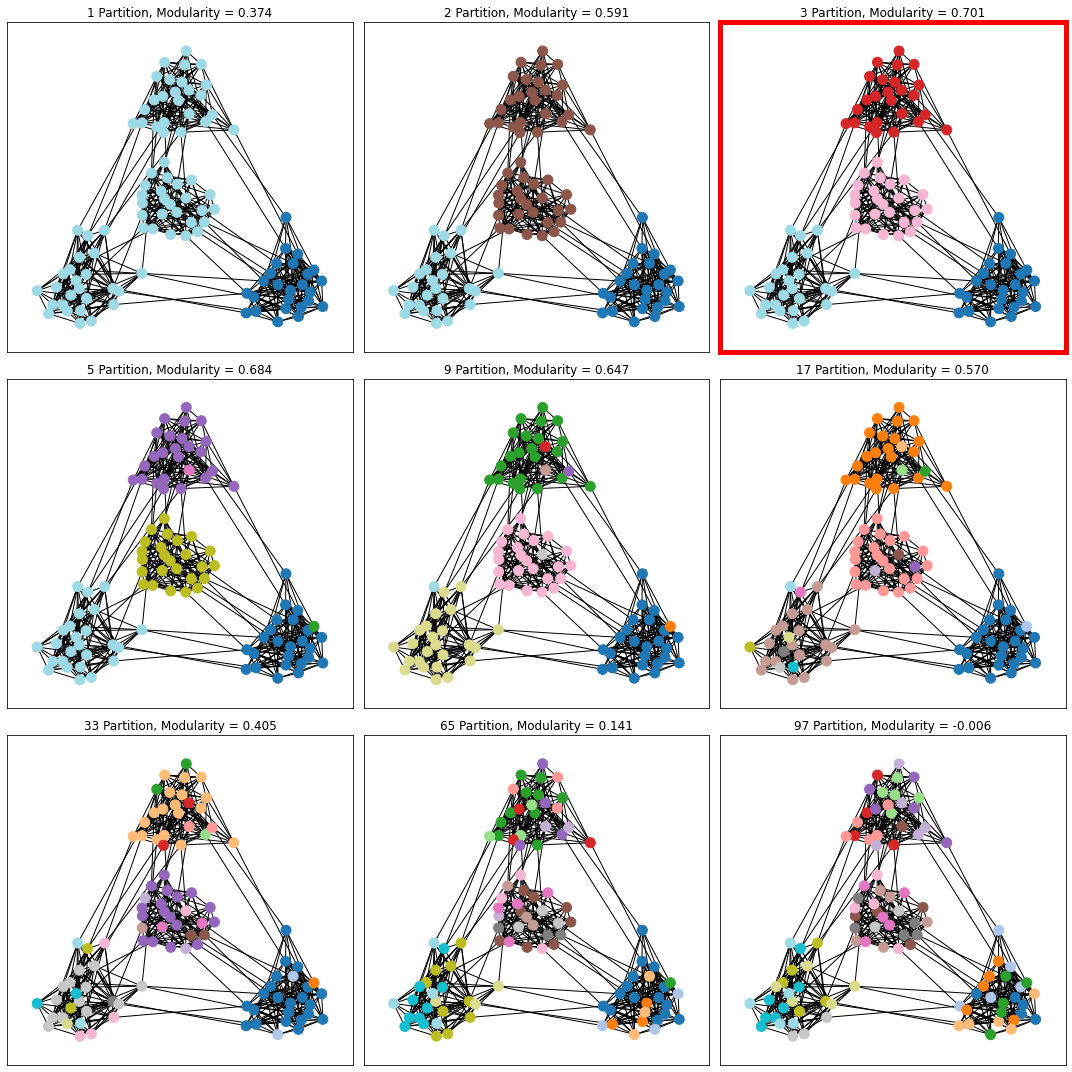

In [152]:
f,axs = plt.subplots(3,3,figsize=(15,15))

# Make a consistent layout
pos = nx.layout.spring_layout(sbm_easy_g)

# Loop through the partitions
for i,(k,p) in enumerate(gn_partitions.items()):
    
    # Map the nodes to communities
    _assignments = {n:i for i,ns in enumerate(map(sorted,p)) for n in ns}
    
    # Flatten the plotting axes
    _ax = axs.flatten()[i]
    
    # Draw the network
    nx.draw_networkx(
        sbm_easy_g,
        with_labels=False,
        ax=_ax,
        pos=pos,
        node_size=100,
        node_color=list(_assignments.values()),
        cmap='tab20'
    )
    
    # Compute the modularity score
    _modularity = nx.community.modularity(sbm_easy_g,p)
    
    # Include some stats in the title
    _ax.set_title('{0} Partition, Modularity = {1:.3f}'.format(k+1,_modularity))
    
for pos in ['top','bottom','right','left']:
    axs[0,2].spines[pos].set_edgecolor('r')
    axs[0,2].spines[pos].set_linewidth(5)
    
f.tight_layout()
f.set_facecolor('w')
f.savefig('girvan_newman_visualizations_modularity.png',dpi=300,bbox_inches='tight')

### Exercise

Repeat for the medium and hard SBM networks.